In [1]:
print('hello world')

hello world


In [2]:
import datetime
import sys
sys.path.append('/home/s94zalek/shape_matching')

import math
import time
from os import path as osp

import torch.cuda

from datasets import build_dataloader, build_dataset
from datasets.data_sampler import EnlargedSampler

from models import build_model
from utils import (AvgTimer, MessageLogger, get_env_info, get_root_logger,
                   init_tb_logger)
from utils.options import dict2str, parse_options

from train import create_train_val_dataloader

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False)

opt['root_path'] = root_path

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240407_143728


In [4]:
# data_x = test_set[15]['first']
# data_y = test_set[15]['second']

# get 15th element from test dataloader
for i, data in enumerate(test_loader):
    if i == 15:
        data_x = data['first']
        data_y = data['second']
        break

list(data_x.keys())

['name',
 'verts',
 'faces',
 'evecs',
 'evecs_trans',
 'evals',
 'mass',
 'L',
 'dist',
 'corr']

In [5]:
data_x['evecs_trans'].shape

torch.Size([1, 200, 5000])

In [31]:
# add indicator function for each vertex
feat_x = torch.arange(data_x['verts'].shape[-2]).unsqueeze(0)
feat_y = torch.arange(data_y['verts'].shape[-2]).unsqueeze(0)

print(feat_x.shape)
print(feat_x)

torch.Size([1, 5000])
tensor([[   0,    1,    2,  ..., 4997, 4998, 4999]])


In [25]:
print(data_x['evecs_trans'].shape)
print(data_x['evecs_trans'])

torch.Size([1, 200, 5000])
tensor([[[ 1.2751e-04,  2.8121e-04,  2.7776e-05,  ...,  3.4750e-05,
           4.3913e-05,  4.4624e-05],
         [ 1.3622e-04,  2.9422e-04,  2.9059e-05,  ..., -6.1515e-05,
           3.6716e-05,  3.5117e-05],
         [ 3.0094e-06,  6.3217e-06,  6.3915e-07,  ..., -9.2430e-05,
           2.3609e-06,  2.2913e-06],
         ...,
         [ 3.4717e-05,  8.8679e-05, -2.9908e-05,  ...,  1.8297e-05,
           3.0527e-05,  1.5647e-05],
         [-9.9828e-06,  7.6616e-04,  3.2119e-05,  ..., -7.6826e-06,
           4.0060e-05,  2.2943e-05],
         [ 4.8503e-05, -2.9837e-04,  1.6142e-05,  ...,  2.9916e-05,
           2.0380e-05,  3.8193e-05]]])


In [32]:
feat_x_fspace = data_x['evecs_trans'][:, :, feat_x[0, :]]
feat_y_fspace = data_y['evecs_trans'][:, :, feat_y[0, :]]

print(feat_x_fspace.shape)
print(feat_x_fspace)

torch.Size([1, 200, 5000])
tensor([[[ 1.2751e-04,  2.8121e-04,  2.7776e-05,  ...,  3.4750e-05,
           4.3913e-05,  4.4624e-05],
         [ 1.3622e-04,  2.9422e-04,  2.9059e-05,  ..., -6.1515e-05,
           3.6716e-05,  3.5117e-05],
         [ 3.0094e-06,  6.3217e-06,  6.3915e-07,  ..., -9.2430e-05,
           2.3609e-06,  2.2913e-06],
         ...,
         [ 3.4717e-05,  8.8679e-05, -2.9908e-05,  ...,  1.8297e-05,
           3.0527e-05,  1.5647e-05],
         [-9.9828e-06,  7.6616e-04,  3.2119e-05,  ..., -7.6826e-06,
           4.0060e-05,  2.2943e-05],
         [ 4.8503e-05, -2.9837e-04,  1.6142e-05,  ...,  2.9916e-05,
           2.0380e-05,  3.8193e-05]]])


In [7]:
feat_x_fspace.shape

torch.Size([1, 200, 5000])

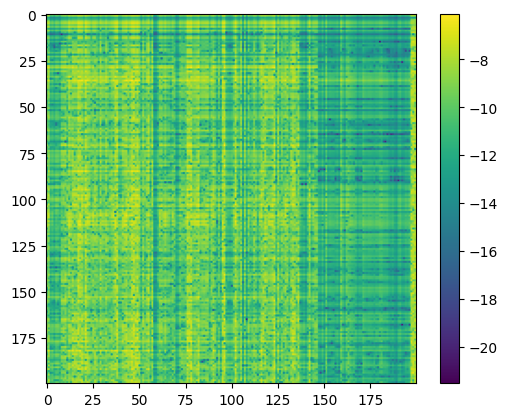

In [8]:
# plot feat_x_fspace.squeeze(0)
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.log(np.abs(feat_x_fspace[0].detach().numpy()))[:200, :200])
plt.colorbar()
plt.show()

In [33]:
feat_y_fspace.shape

torch.Size([1, 200, 5000])

In [34]:
import networks.fmap_network as fmap_network

def compute_functional_map(A, B, evals_x, evals_y, lmbda=100, resolvant_gamma=0.5):
    # A = torch.bmm(evecs_trans_x, feat_x)  # [B, K, C]
    # B = torch.bmm(evecs_trans_y, feat_y)  # [B, K, C]

    D = fmap_network.get_mask(evals_x, evals_y, resolvant_gamma)  # [B, K, K]

    A_t = A.transpose(1, 2)  # [B, C, K]
    A_A_t = torch.bmm(A, A_t)  # [B, K, K]
    B_A_t = torch.bmm(B, A_t)  # [B, K, K]

    C_i = []
    for i in range(evals_x.shape[1]):
        D_i = torch.cat([torch.diag(D[bs, i, :].flatten()).unsqueeze(0) for bs in range(evals_x.shape[0])], dim=0)
        C = torch.bmm(torch.inverse(A_A_t + lmbda * D_i), B_A_t[:, [i], :].transpose(1, 2))
        C_i.append(C.transpose(1, 2))

    Cxy = torch.cat(C_i, dim=1)
    return Cxy

Cxy = compute_functional_map(
    feat_x_fspace.cuda(),
    feat_y_fspace.cuda(),
    data_x['evals'].cuda(),
    data_y['evals'].cuda()
    )
Cxy

tensor([[[-6.9516e-01,  9.5476e-06,  2.4741e-05,  ...,  4.7001e-08,
          -6.9240e-08, -1.4384e-07],
         [ 1.7904e-04, -3.8157e-02,  1.3707e-03,  ...,  7.2294e-08,
           1.2392e-07, -7.5283e-08],
         [ 1.9907e-05, -9.6305e-03,  1.2062e-01,  ...,  8.8009e-08,
          -2.9574e-08,  1.8707e-07],
         ...,
         [-1.2313e-07, -7.5184e-08,  5.7328e-08,  ..., -2.2652e-03,
           1.9313e-02,  2.1062e-02],
         [-6.2717e-08, -1.1219e-08, -1.8182e-07,  ..., -4.1438e-03,
           1.3956e-02,  2.3488e-02],
         [-7.2987e-08, -6.8103e-09, -1.7883e-07,  ...,  4.1805e-03,
           9.4679e-03, -8.4945e-03]]], device='cuda:0')

In [64]:
print(Cxy @ feat_x_fspace.cuda())
print(feat_y_fspace.cuda())
print(torch.norm(Cxy @ feat_x_fspace.cuda() - feat_y_fspace.cuda()))
print(torch.norm(Cxy @ feat_y_fspace.cuda() - feat_x_fspace.cuda()))
print(torch.sum(feat_x_fspace), torch.sum(feat_y_fspace))

tensor([[[-8.8632e-05, -1.9547e-04, -1.9308e-05,  ..., -2.4161e-05,
          -3.0526e-05, -3.1021e-05],
         [-5.1863e-06, -1.1199e-05, -1.1060e-06,  ...,  2.2167e-06,
          -1.3910e-06, -1.3293e-06],
         [-9.4116e-07, -2.0565e-06, -2.0121e-07,  ..., -1.0548e-05,
          -5.8215e-08, -5.2413e-08],
         ...,
         [ 5.0448e-07,  9.5602e-06,  1.4352e-06,  ...,  9.8743e-07,
           2.7443e-06,  2.9721e-06],
         [ 1.2846e-06,  6.9778e-06,  1.0642e-06,  ...,  8.1844e-07,
           1.1584e-06,  1.3689e-06],
         [-4.1732e-07,  8.5154e-06, -6.9274e-08,  ..., -2.9702e-07,
          -3.8123e-08, -4.9437e-07]]], device='cuda:0')
tensor([[[-1.1545e-04, -2.3495e-04, -5.8347e-05,  ..., -1.9931e-05,
          -1.7091e-05, -2.4142e-05],
         [-1.1541e-04, -2.3291e-04, -5.7674e-05,  ...,  3.2310e-05,
           2.7720e-05,  3.9153e-05],
         [ 4.3301e-06,  8.6727e-06,  2.1566e-06,  ..., -5.2902e-05,
          -4.5395e-05, -6.4116e-05],
         ...,
        

In [59]:
# find distance between Cxy @ Cxy.transpose(1, 2) and identity matrix
Cxy_Cxy_t = torch.bmm(Cxy, Cxy.transpose(1, 2))
Cxy_t_Cxy = torch.bmm(Cxy.transpose(1, 2), Cxy)

print(torch.norm(Cxy_Cxy_t - torch.eye(Cxy_Cxy_t.shape[-1]).cuda()))
print(torch.norm(Cxy_t_Cxy - torch.eye(Cxy_t_Cxy.shape[-1]).cuda()))

# 

tensor(14.1079, device='cuda:0')
tensor(14.1079, device='cuda:0')


In [55]:
feat_x_fspace.shape

torch.Size([1, 200, 5000])

In [57]:
from utils.fmap_util import nn_query, fmap2pointmap

p2p = nn_query(feat_x_fspace, feat_y_fspace)
p2p_inv = nn_query(feat_y_fspace, feat_x_fspace)

print(p2p)
print(p2p_inv)

tensor([[84, 84,  2,  3, 84, 84,  6, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84]])
tensor([[82, 82,  2,  3, 82, 82,  6, 77, 82, 82, 82, 77, 82, 82, 77, 77, 82, 77,
         

tensor([[84, 84,  2,  3, 84, 84,  6, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84]])

In [50]:
!ls

checkpoints	figures  networks	__pycache__	  texture_transfer.py
data		LICENSE  notebooks	README.md	  train.py
datasets	losses	 options	requirements.txt  utils
environment.sh	metrics  output		results
experiments	models	 preprocess.py	test.py


In [46]:
!python test.py --opt options/test/faust.yaml 

Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240407_164112
2024-04-07 16:41:12,795 INFO: 
Version Information: 
	Python: 3.8.19
	PyTorch: 2.2.2+cu121
	TorchVision: 0.17.2+cu121
2024-04-07 16:41:12,795 INFO: 
  name: faust
  backend: dp
  type: FMNetModel
  num_gpu: 1
  manual_seed: 1234
  non-isometric: False
  partial: False
  visualize: True
  path:[
    resume_state: checkpoints/faust.pth
    resume: False
    results_root: /home/s94zalek/shape_matching/results/faust
    log: /home/s94zalek/shape_matching/results/faust/log
    visualization: /home/s94zalek/shape_matching/results/faust/visualization
  ]
  datasets:[
    test_dataset:[
      name: FaustVal
      type: PairFaustDataset
      phase: test
      data_root: data/FAUST_r/
      return_evecs: True
      return_faces: True
      num_evecs: 200
      return_corr: True
      return_dist: True
    ]
  ]
  networks:[
    feature_extractor:[
      type: DiffusionNet